# Import libraries

In [485]:
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

# Read dataset image

In [486]:
test_dir = "data-set/test"
valid_dir = "data-set/valid"
train_dir = "data-set/train"

## Test dataset

In [487]:
img_height = 224
img_width = 224
batch_size = 32

#import 
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred', # will base labels on folder
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='bilinear', # resizing method 
    batch_size=batch_size, #for better generalization/training
    shuffle=False # Typically, you don't shuffle the validation or test sets
)

#show classes
print(test_ds.class_names)

Found 200 files belonging to 2 classes.
['clean_water', 'microplastic']


## Train dataset

In [488]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred', # will base labels on folder
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='bilinear', # resizing method 
    batch_size=batch_size, #for better generalization
    shuffle=False # Typically, you don't shuffle the validation or test sets
)

#show classes
print(train_ds.class_names)

Found 1154 files belonging to 2 classes.
['clean_water', 'microplastic']


### For viewing purposes of image only

Before scaled max:  255.0
Before scaled max:  0.0
Shape:  (32, 224, 224, 3)


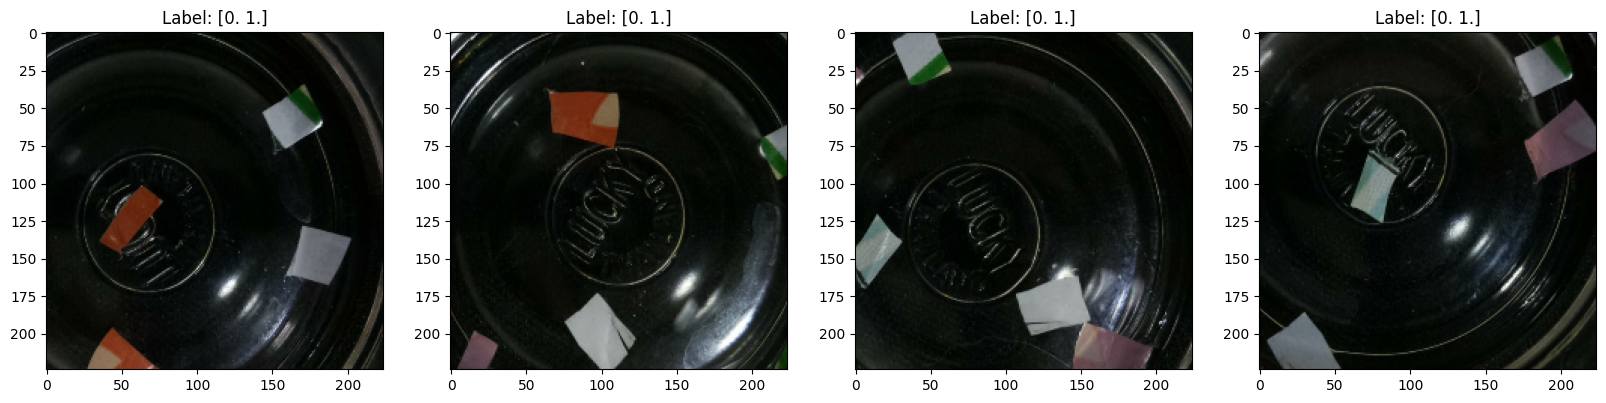

In [489]:
# 32 images is contained in one batch
# 200 / 32  = 6 batch with remaining 8 images which leaves us to the last batch

# skip and start in batch 30
batch_before = next(train_ds.skip(30).take(1).as_numpy_iterator())
print("Before scaled max: ", batch_before[0].max())
print("Before scaled max: ", batch_before[0].min())

images, labels = batch_before
print("Shape: ",images.shape)

fig, axes = plt.subplots(ncols=4, figsize=(20, 20))

for i in range(4):
    axes[i].imshow(images[i].astype(int))
    axes[i].set_title(f"Label: {labels[i]}")

plt.show()


## Validation dataset

In [490]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=valid_dir,
    labels='inferred', # will base labels on folder
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='bilinear', # resizing method 
    batch_size=batch_size, #for better generalization
    shuffle=False # Typically, you don't shuffle the validation or test sets
)

#show classes
print(valid_ds.class_names)

Found 208 files belonging to 2 classes.
['clean_water', 'microplastic']


# Normalize dataset

In [491]:
# convert image 0-1
# black - 0
# white - 1

train_ds = train_ds.map(lambda x, y: (x/255, y))
valid_ds = valid_ds.map(lambda x, y: (x/255, y))
test_ds = test_ds.map(lambda x, y: (x/255, y))

# print(valid_ds.as_numpy_iterator().next()[0].min())


### View scaled dataset

Scaled max:  1.0
Scaled min:  0.0


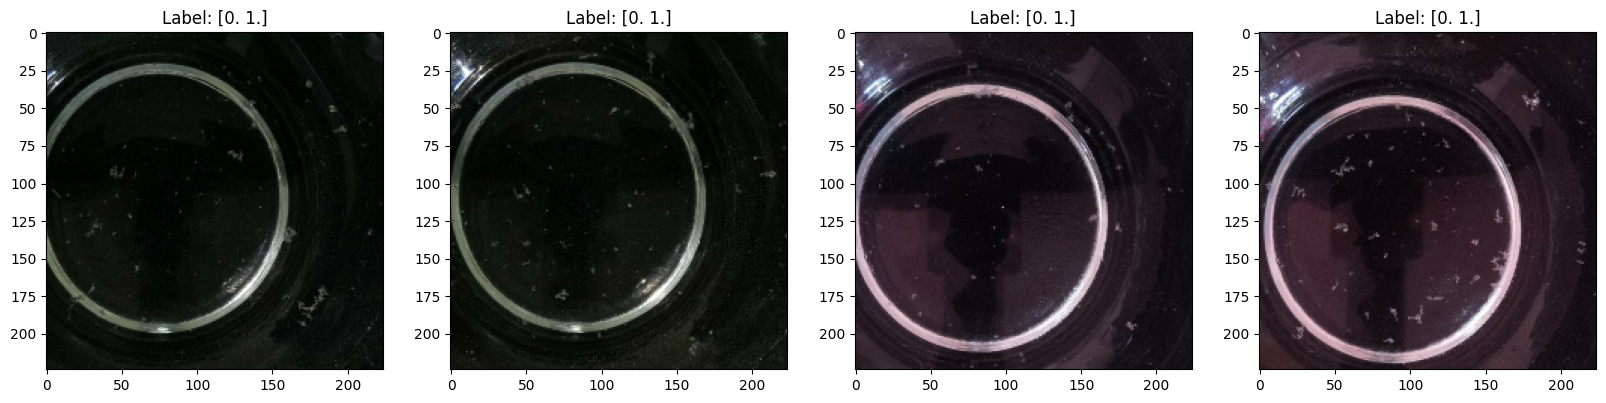

In [492]:
# 32 images is contained in one batch
# 200 / 32  = 6 batch with remaining 8 images which leaves us to the last batch

# skip and start in batch 30
batch_scaled = next(train_ds.skip(20).take(1).as_numpy_iterator())
print("Scaled max: ",batch_scaled[0].max())
print("Scaled min: ",batch_scaled[0].min())
# print("after_scaled: ",batch_scaled)

images_, labels_ = batch_scaled

fig, axes = plt.subplots(ncols=4, figsize=(20, 20))

for i in range(4):
    axes[i].imshow(images_[i])
    axes[i].set_title(f"Label: {labels_[i]}")

plt.show()

# Optimize dataset

In [493]:
#cache dataset for better performance and less time of getting the image
Autotune = tf.data.AUTOTUNE

#cache - keep data in memory
#prefetch - prepares the next batch while your model is training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=Autotune) # Shuffling ensures it learns real features, not the sequence.
valid_ds = valid_ds.cache().prefetch(buffer_size=Autotune)
test_ds = test_ds.cache().prefetch(buffer_size=Autotune)